# **概要**

同種造血幹細胞移植（HCT）患者の生存予測を改善することは、重要な医療課題です。現在の予測モデルは、社会経済的地位、人種、地理的要因に関連する格差を十分に考慮できていないことが多いです。これらのギャップに対処することは、患者ケアの向上、資源の最適な活用、医療システムへの信頼回復において極めて重要です。

このコンペティションでは、参加者が予測モデリングを進化させ、さまざまなグループの患者に対して生存予測が正確で公正であることを保証することを目指します。実際の状況を反映しながら**患者プライバシーを保護する合成データを使用することで**、参加者は多様な背景や条件をより効果的に考慮したモデルを構築・改善できます。

課題は、**同種HCTの生存予測において精度と公平性を高める先進的な予測モデルを開発することです**。多様なデータソースを結び付け、アルゴリズムを洗練させ、バイアスを軽減することで、異なる人種グループの患者に対して公平な結果を確保することが目標です。 あなたの取り組みは、より公正かつ効果的な医療環境の実現に貢献し、すべての患者が適切なケアを受けられるようにします。

## **評価指標**

本コンペティションにおける予測精度の評価では、「人種グループごとに独立して考慮する」という特性を持つ**階層化コンコーダンス指数（Stratified Concordance Index, C-index）**という専門的な指標を使用します。この方法により、異なる患者集団、特に移植結果における人種間の格差に注目しつつ、モデルの予測性能を公平性を重視して評価することが可能です。

コンコーダンス指数（Concordance Index）
コンコーダンス指数は、モデルの識別力（discrimination power）の全体的な評価を表します。具体的には、個々のリスクスコアに基づいて生存時間を正確に順位付けできるモデルの能力を示します。この指数は以下の式で計算できます：

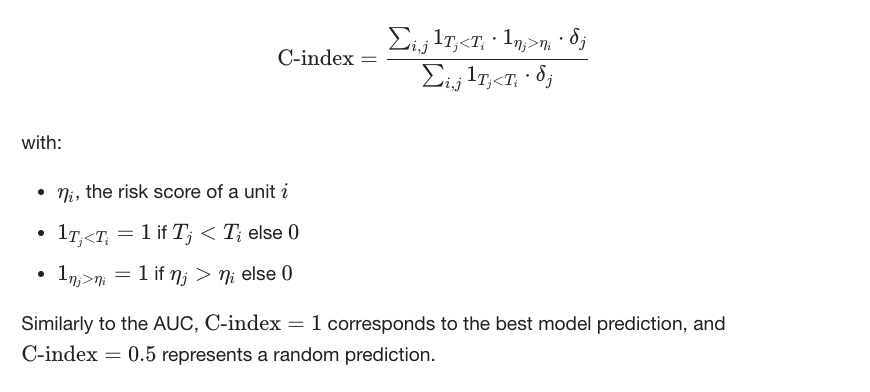

このコンペティションでは、**各人種グループの結果がモデル評価において等しく重み付けされるように**、人種階層化を考慮して標準C指数を調整する。 すなわち、異なる人種カテゴリー間のCインデックスの平均が大きく、人種カテゴリー間のCインデックスの標準偏差が小さければ、スコアは良くなる。 この値は0から1の範囲で、1が理論上の満点であるが、打ち切られた結果のため、この値は実際には低くなる。

# **Dependincies**

In [1]:
%%capture
!pip install lightgbm==3.3.2
!pip install catboost==1.2.2
!pip install xgboost==2.0.3
!pip install optuna
!pip install timm
!pip install pyspellchecker
!pip install lifelines

In [2]:
import pandas as pd
import numpy as np
from time import time
import re
import gc
import shutil
import os
import math
import random
import importlib
import warnings
import pickle
import joblib
from tqdm import tqdm
import sys
from pathlib import Path
import string

from scipy.stats import skew, kurtosis
from collections import Counter,defaultdict
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost as cat, gc
import xgboost

print(lgb.__version__)
print(cat.__version__)
print(xgboost.__version__)

from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBClassifier

import optuna

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.nn.functional as F

from transformers import AutoModel,AutoTokenizer
from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
sys.path.append('/notebooks/CIBMTR/utils')

3.3.2
1.2.2
2.0.3


2025-01-12 05:02:42.372132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 05:02:42.372234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 05:02:42.450052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 05:02:42.614559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 05:02:44.055549: W tensorflow/compiler/tf2

In [39]:
import utils as my_utils
from metric import score

In [4]:
FE = my_utils.CIBMTR_FE(mode='train')

In [5]:
class clr:
    BLACK     = '\033[30m'
    RED       = '\033[31m'
    GREEN     = '\033[32m'
    YELLOW    = '\033[33m'
    BLUE      = '\033[34m'
    PURPLE    = '\033[35m'
    CYAN      = '\033[36m'
    WHITE     = '\033[37m'
    END       = '\033[0m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    INVISIBLE = '\033[08m'
    REVERCE   = '\033[07m'
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'

my_colors = ["#761D80", "#9926A6", "#9C69C9",
             "#6C91BF", "#58BCC6", "#4AD1B2",
             "#4BF1B2"]

CMAP1 = ListedColormap(my_colors)

In [6]:
def red(x):
    return clr.RED+f'{x}'+clr.END

# **CONFIG**

In [7]:
train_path = '/notebooks/CIBMTR/data/train.csv'
train_dic_path = '/notebooks/CIBMTR/data/data_dictionary.csv'

test_path = '/notebooks/CIBMTR/data/test.csv'
sub_path = '/notebooks/CIBMTR/data/sample_submission.csv'

In [8]:
train = pd.read_csv(train_path)
# dictionary_tow = pd.read_csv(train_dic_path)
dictionary = pd.read_csv('/notebooks/CIBMTR/output/dictionary.csv', encoding='cp932').drop('Unnamed: 0', axis=1)
test = pd.read_csv(test_path)
submission = pd.read_csv(sub_path)

In [9]:
TARGETS = ['efs_time', 'efs']

# **DICTIONARY**

In [10]:
dictionary.head()

,variable,description,Translate,type,values,translate
0,dri_score,Refined disease risk index,"**造血幹細胞移植（Hematopoietic Cell Transplantation, ...",Categorical,['Intermediate' 'High' 'N/A - non-malignant in...,[「中」「高」「該当なし - 非悪性適応症」「該当なし - 小児」\n「高 - TED AM...
1,psych_disturb,Psychiatric disturbance,精神障害,Categorical,['Yes' 'No' nan 'Not done'],[「はい」「いいえ」ナン「まだ」]
2,cyto_score,Cytogenetic score,遺伝子異常や染色体異常,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...,['中間' '良好' '悪い' '未定' nan '普通' 'その他' '未テスト'】
3,diabetes,Diabetes,糖尿病,Categorical,['No' 'Yes' nan 'Not done'],[「いいえ」「はい」ナン「まだ終わっていません」]
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,HLA-C でのレシピエント / 第 1 ドナーの対立遺伝子レベル (高分解能) の一致,Numerical,NaN,NaN


In [11]:
var_list = dictionary['variable'].unique()
for var in sorted(var_list):
    sentense=dictionary[dictionary['variable']==var]['Translate'].values[0]
    print(clr.RED+f'{var}:'+clr.END, sentense)

age_at_hct: HCT時の年齢
arrhythmia: 不整脈
cardiac: 心臓に関連する疾患
cmv_status: ドナー/レシピエントの CMV 血清状態.Donor/recipient CMV serostatusは、移植後のCMV感染リスクを評価し、適切な予防・治療計画を立てるために重要な指標です。特に、D+/R-の組み合わせでは特別な注意が必要であり、抗ウイルス薬や定期モニタリングによる慎重な管理が求められます。
comorbidity_score: 造血幹細胞移植（Hematopoietic Cell Transplantation, HCT）を受ける患者の**併存疾患（comorbidities）**を評価し、それが移植後の生存率や予後にどのように影響するかを予測するための指標です
conditioning_intensity: 移植の成功に向けた前処置の最適な強度を計画するために重要な指標です。
cyto_score: 遺伝子異常や染色体異常
cyto_score_detail: Cytogenetics for DRI (AML/MDS) は、患者の予後を評価し、適切な治療戦略を立てるための重要な情報です。細胞遺伝学的リスク分類は、移植の適応や成功率に大きな影響を与えるため、移植前の評価プロセスに不可欠です。
diabetes: 糖尿病
donor_age: ドナーの年齢
donor_related: 血縁ドナーと非血縁ドナー
dri_score: **造血幹細胞移植（Hematopoietic Cell Transplantation, HCT）**を受ける患者の疾患リスクをより精密に評価するために開発された指標です。これは、移植後の生存率や治療成績を予測するために用いられます。
efs: nan
efs_time: nan
ethnicity: 民族
graft_type: *造血幹細胞移植（Hematopoietic Cell Transplantation, HCT）において、使用される移植片（graft）**の由来や種類を指します。移植片の種類は、治療効果や移植後の合併症リスクに影響を与えるため、患者の状態や疾患に応じて慎重に選択されます。
gvhd_proph: **造血幹細胞移植（Hematopoietic Cell 

# **TARGET**

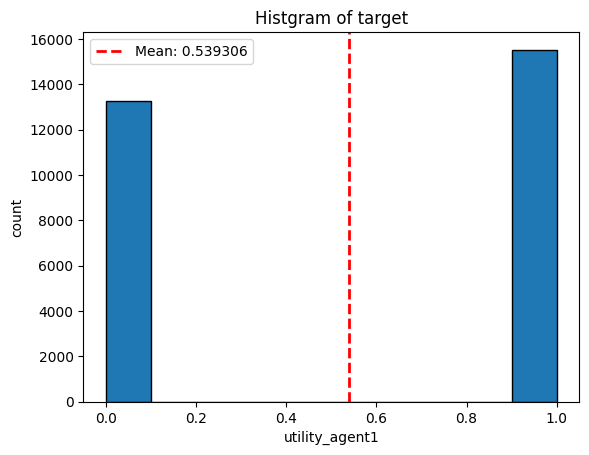

In [12]:
tmp = train['efs']
plt.hist(tmp, edgecolor='black')
plt.title('Histgram of target')
plt.xlabel('utility_agent1')
plt.ylabel('count')

mean_value = tmp.mean()
plt.axvline(mean_value, 
            color='red', 
            linestyle='dashed',
            linewidth=2, 
            label=f'Mean: {mean_value:.6f}')
plt.legend()
plt.show()

In [13]:
data = train
data.shape

(28800, 60)

In [14]:
categorical_cols = data.drop(columns=TARGETS + ['ID']).select_dtypes(include=['object', 'category']).columns.to_list()
numerical_cols = data.drop(columns=TARGETS + ['ID']).select_dtypes(include=['number']).columns.to_list()

print(clr.RED + f'categorical_cols : {len(categorical_cols)}')
print(clr.RED + f'num_cols : {len(numerical_cols)}')

categorical_cols : 35
num_cols : 22


# **CATEGORICAL DATA**

In [15]:
categorical_cols

['dri_score',
 'psych_disturb',
 'cyto_score',
 'diabetes',
 'tbi_status',
 'arrhythmia',
 'graft_type',
 'vent_hist',
 'renal_issue',
 'pulm_severe',
 'prim_disease_hct',
 'cmv_status',
 'tce_imm_match',
 'rituximab',
 'prod_type',
 'cyto_score_detail',
 'conditioning_intensity',
 'ethnicity',
 'obesity',
 'mrd_hct',
 'in_vivo_tcd',
 'tce_match',
 'hepatic_severe',
 'prior_tumor',
 'peptic_ulcer',
 'gvhd_proph',
 'rheum_issue',
 'sex_match',
 'race_group',
 'hepatic_mild',
 'tce_div_match',
 'donor_related',
 'melphalan_dose',
 'cardiac',
 'pulm_moderate']

In [16]:
####
# categorycal dataの分析
####
categorical_data = data[categorical_cols]
display(categorical_data.head(3))

,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,...,gvhd_proph,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate
0,N/A - non-malignant indication,No,NaN,No,No TBI,No,Bone marrow,No,No,No,...,FKalone,No,M-F,More than one race,No,NaN,Unrelated,"N/A, Mel not given",No,No
1,Intermediate,No,Intermediate,No,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,...,Other GVHD Prophylaxis,No,F-F,Asian,No,Permissive mismatched,Related,"N/A, Mel not given",No,Yes
2,N/A - non-malignant indication,No,NaN,No,No TBI,No,Bone marrow,No,No,No,...,Cyclophosphamide alone,No,F-M,More than one race,No,Permissive mismatched,Related,"N/A, Mel not given",No,No


## **NA CHECK**

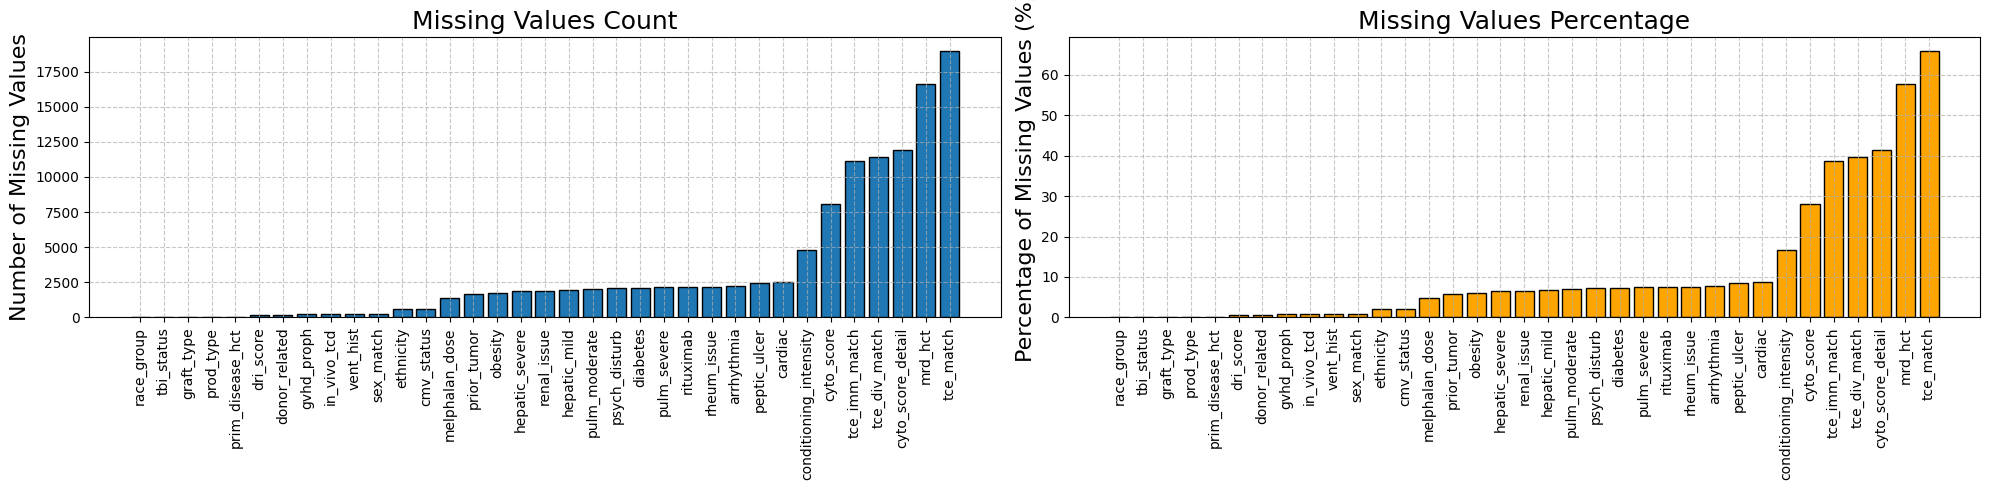

In [17]:
# 修正されたコード：2つのプロットを並べて表示するための設定
tmp = categorical_data.isna().sum().sort_values()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# 欠損値の数をバーグラフに描画（左側の軸）
axes[0].bar(x=tmp.index, height=tmp.values, edgecolor='black')
axes[0].set_ylabel('Number of Missing Values', fontsize=16)
axes[0].tick_params(axis='x', rotation=90, labelsize=10)  # X軸ラベルを回転
axes[0].tick_params(axis='y', labelsize=10)  # Y軸ラベルのサイズを調整
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].set_title('Missing Values Count', fontsize=18)

# 欠損値の割合をバーグラフに描画（右側の軸）
missing_percentage = (tmp / data.shape[0]) * 100
axes[1].bar(x=tmp.index, height=missing_percentage, edgecolor='black', color='orange')
axes[1].set_ylabel('Percentage of Missing Values (%)', fontsize=16)
axes[1].tick_params(axis='x', rotation=90, labelsize=10)  # X軸ラベルを回転
axes[1].tick_params(axis='y', labelsize=10)  # Y軸ラベルのサイズを調整
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].set_title('Missing Values Percentage', fontsize=18)

plt.tight_layout()
plt.show()


## **VALUES COUNTS**

In [18]:
# 造血幹細胞移植 (Hematopoietic stem cell transplantation, HCT)
# dict_cat

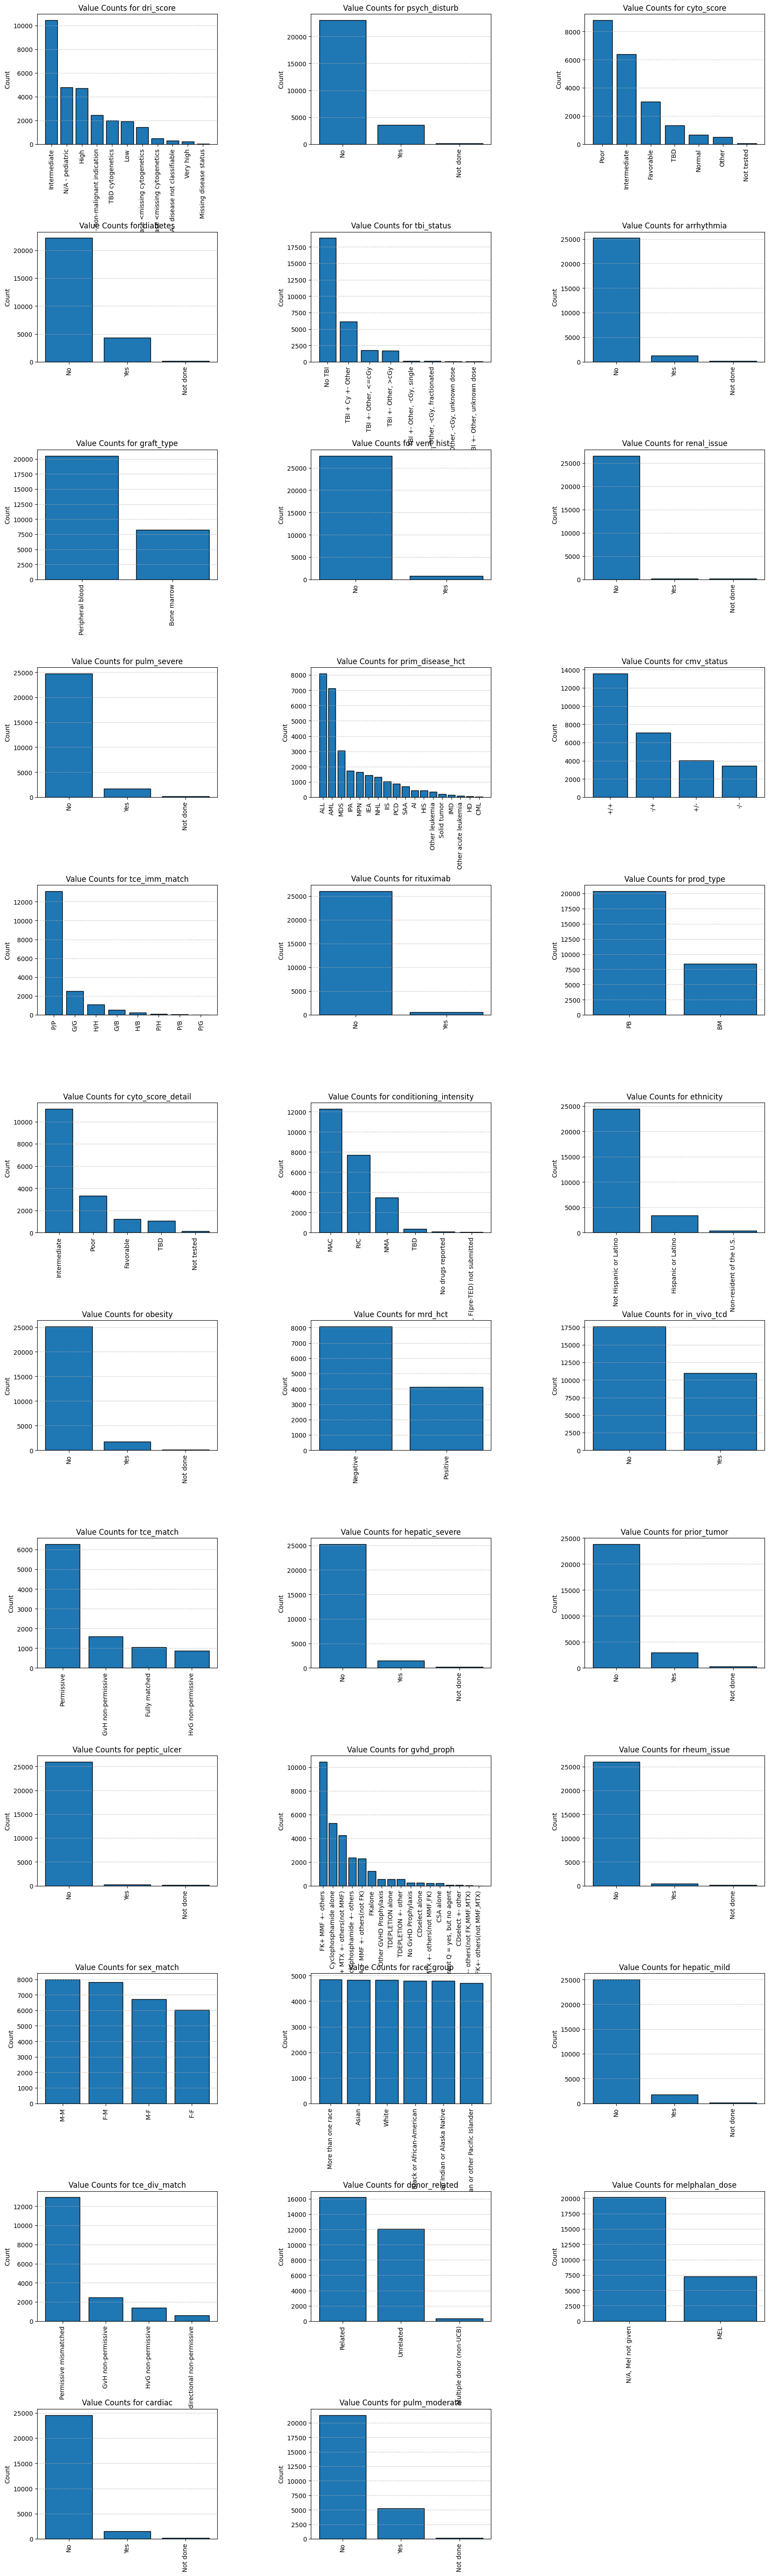

In [19]:
# 黒い線を追加してバーをプロット
import math

num_cols = len(categorical_cols)
cols_per_row = 3  # 1行あたりの列数を5に設定
num_rows = math.ceil(num_cols / cols_per_row)  # 必要な行数を計算

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, 5 * num_rows))
fig.tight_layout(pad=12.0)

# 各列をプロット
for i, col in enumerate(categorical_cols):
    row, col_position = divmod(i, cols_per_row)
    ax = axes[row, col_position] if num_rows > 1 else axes[col_position]
    value_counts = data[col].value_counts()
    bars = ax.bar(value_counts.index, value_counts.values, edgecolor='black')  # edgecolorで黒い線を追加
    ax.set_title(f'Value Counts for {col}')
    ax.tick_params(axis='x', rotation=90)  # X軸ラベルを回転
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# 空のプロットを非表示にする
for j in range(num_cols, num_rows * cols_per_row):
    row, col_position = divmod(j, cols_per_row)
    fig.delaxes(axes[row, col_position] if num_rows > 1 else axes[col_position])

plt.show()

# **NUMERICAL DATA**

In [20]:
numerical_cols

['hla_match_c_high',
 'hla_high_res_8',
 'hla_low_res_6',
 'hla_high_res_6',
 'hla_high_res_10',
 'hla_match_dqb1_high',
 'hla_nmdp_6',
 'hla_match_c_low',
 'hla_match_drb1_low',
 'hla_match_dqb1_low',
 'year_hct',
 'hla_match_a_high',
 'donor_age',
 'hla_match_b_low',
 'age_at_hct',
 'hla_match_a_low',
 'hla_match_b_high',
 'comorbidity_score',
 'karnofsky_score',
 'hla_low_res_8',
 'hla_match_drb1_high',
 'hla_low_res_10']

In [21]:
numerical_data = data[numerical_cols]

## **NA CHECK**

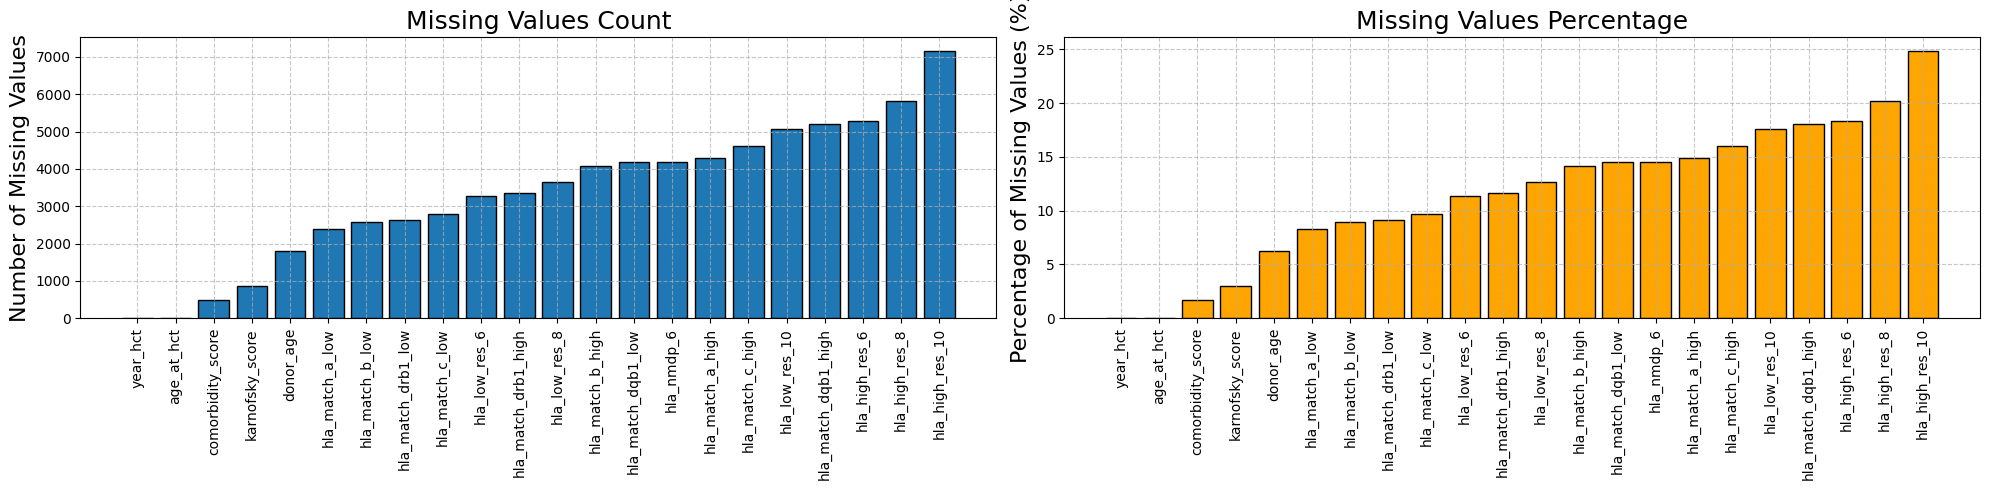

In [22]:
# 修正されたコード：2つのプロットを並べて表示するための設定
tmp = numerical_data.isna().sum().sort_values()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# 欠損値の数をバーグラフに描画（左側の軸）
axes[0].bar(x=tmp.index, height=tmp.values, edgecolor='black')
axes[0].set_ylabel('Number of Missing Values', fontsize=16)
axes[0].tick_params(axis='x', rotation=90, labelsize=10)  # X軸ラベルを回転
axes[0].tick_params(axis='y', labelsize=10)  # Y軸ラベルのサイズを調整
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].set_title('Missing Values Count', fontsize=18)

# 欠損値の割合をバーグラフに描画（右側の軸）
missing_percentage = (tmp / data.shape[0]) * 100
axes[1].bar(x=tmp.index, height=missing_percentage, edgecolor='black', color='orange')
axes[1].set_ylabel('Percentage of Missing Values (%)', fontsize=16)
axes[1].tick_params(axis='x', rotation=90, labelsize=10)  # X軸ラベルを回転
axes[1].tick_params(axis='y', labelsize=10)  # Y軸ラベルのサイズを調整
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].set_title('Missing Values Percentage', fontsize=18)

plt.tight_layout()
plt.show()


## **TARGET Distribution**

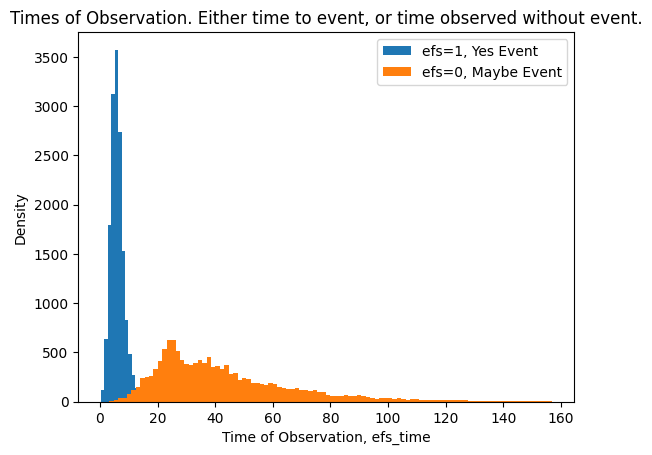

In [23]:
'''
There are two train targets efs and efs_time. 
When efs==1 we know patient had an event and we know time of event is efs_time.
When efs==0 we do not know if patient had an event or not, 
but we do know that patient was without event for at least efs_time
確実にeventが起きる時は(efs=1)、短時間となる場合が多い。
eventが起きない時は(efs=0)、長時間となる場合が多い。
'''

plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

## **VALUES COUNTS**

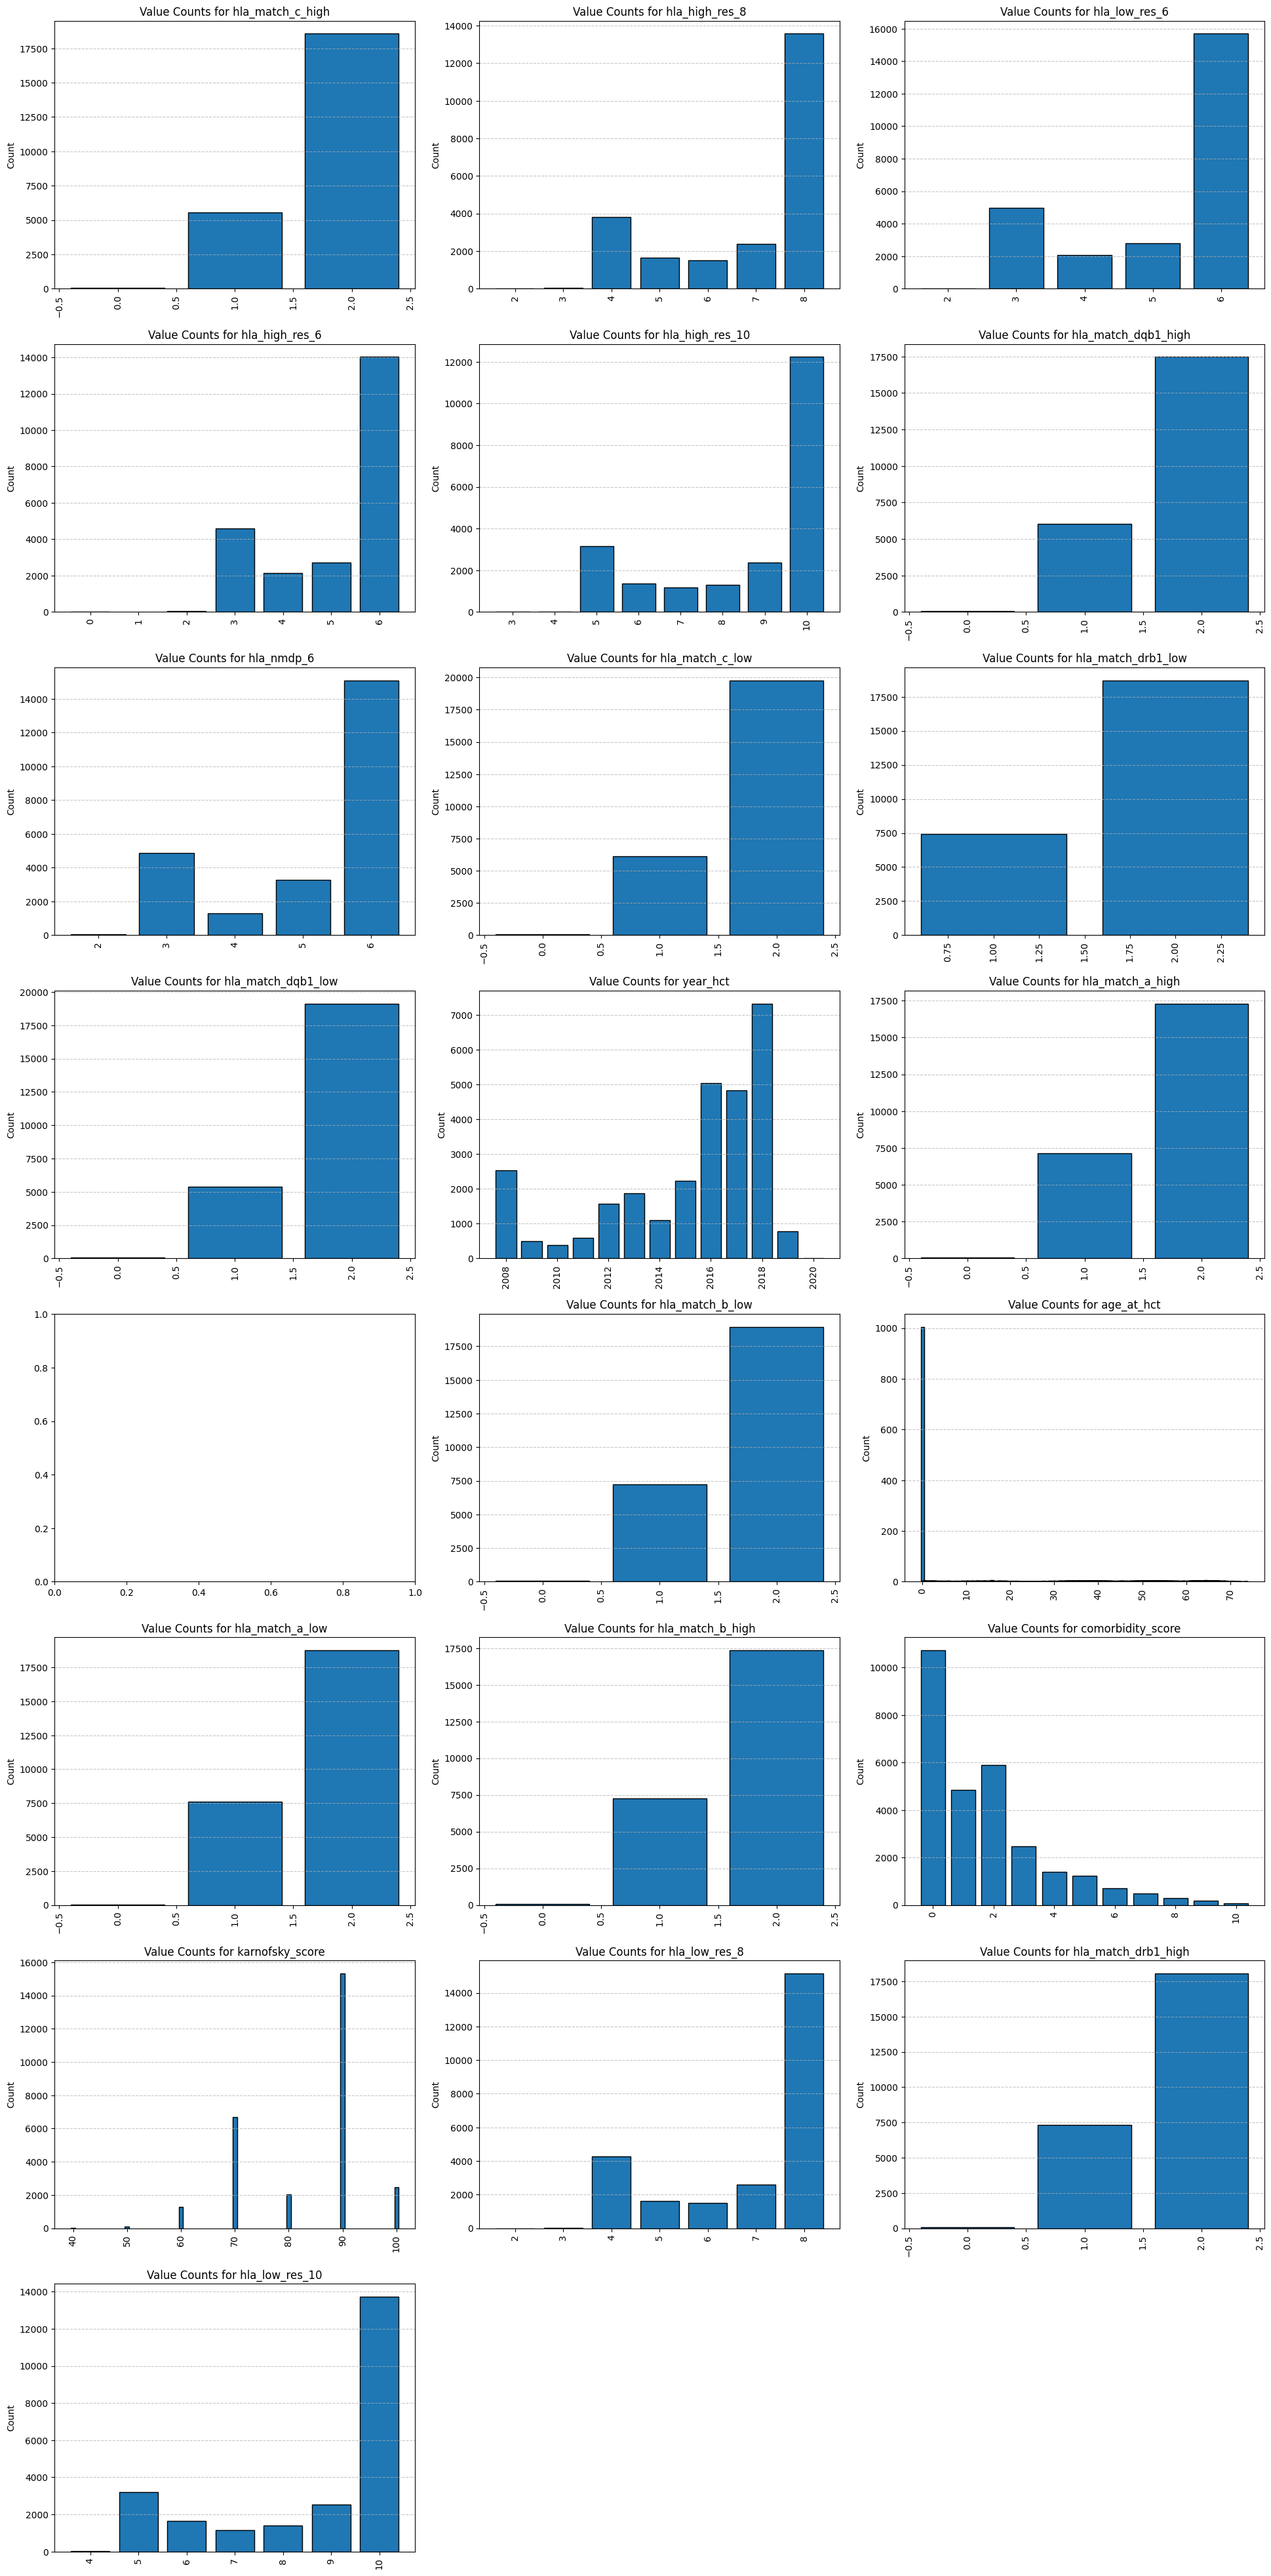

In [24]:
# 黒い線を追加してバーをプロット
import math

num_cols = len(numerical_cols)
cols_per_row = 3  # 1行あたりの列数を5に設定
num_rows = math.ceil(num_cols / cols_per_row)  # 必要な行数を計算

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, 5 * num_rows))
fig.tight_layout(pad=4.0)

# 各列をプロット
for i, col in enumerate(numerical_cols):
    if col in {'efs_time', 'y', 'donor_age'}:
        continue
        
    row, col_position = divmod(i, cols_per_row)
    ax = axes[row, col_position] if num_rows > 1 else axes[col_position]
    value_counts = data[col].value_counts()
    bars = ax.bar(value_counts.index, value_counts.values, edgecolor='black')  # edgecolorで黒い線を追加
    ax.set_title(f'Value Counts for {col}')
    ax.tick_params(axis='x', rotation=90)  # X軸ラベルを回転
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# 空のプロットを非表示にする
for j in range(num_cols, num_rows * cols_per_row):
    row, col_position = divmod(j, cols_per_row)
    fig.delaxes(axes[row, col_position] if num_rows > 1 else axes[col_position])

plt.show()

## **KaplanMeierFitter**

In [25]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

Median Survival Time:9.98


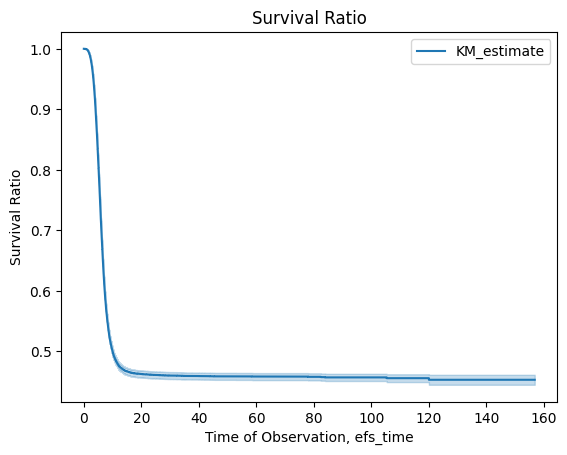

In [26]:
T = data["efs_time"]
E = data["efs"]
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot()
plt.title('Survival Ratio')
plt.xlabel("Time of Observation, efs_time")
plt.ylabel('Survival Ratio')
print(clr.RED + f'Median Survival Time:{kmf.median_survival_time_}' + clr.END)

In [27]:
kind_of_race = data['race_group'].unique().tolist()
kind_of_race

['More than one race',
 'Asian',
 'White',
 'American Indian or Alaska Native',
 'Native Hawaiian or other Pacific Islander',
 'Black or African-American']

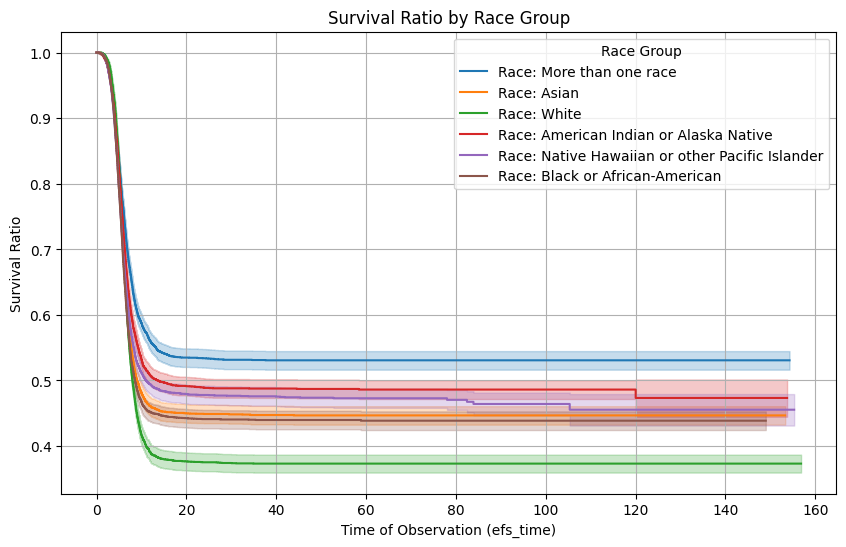

Race: More than one race - Median Survival Time: inf
Race: Asian - Median Survival Time: 9.015
Race: White - Median Survival Time: 7.993
Race: American Indian or Alaska Native - Median Survival Time: 13.754
Race: Native Hawaiian or other Pacific Islander - Median Survival Time: 10.992
Race: Black or African-American - Median Survival Time: 8.562


In [28]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# T: 生存時間, E: イベント発生フラグ
T = data["efs_time"]
E = data["efs"]
kind_of_race = data['race_group'].unique().tolist()

# プロットの設定
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# 人種ごとに Kaplan-Meier 曲線をプロット
for race in kind_of_race:
    race_filter = data['race_group'] == race
    kmf.fit(T[race_filter], event_observed=E[race_filter], label=f'Race: {race}')
    kmf.plot()

# グラフの装飾
plt.title('Survival Ratio by Race Group')
plt.xlabel('Time of Observation (efs_time)')
plt.ylabel('Survival Ratio')
plt.legend(title="Race Group", loc='best')
plt.grid(True)
plt.show()

# 各人種の中央値生存時間を表示
for race in kind_of_race:
    race_filter = data['race_group'] == race
    kmf.fit(T[race_filter], event_observed=E[race_filter])
    print(clr.RED + f"Race: {race} - Median Survival Time: {kmf.median_survival_time_}" + clr.END)

#####
# 白人が断トツで早くeventが起きている。
# アメリカ系インド人、アラスカ系は最も生存確率が高い（Eventが起こりにくい）。
# ついで、ネイティブハワイアンやその他島国、Asia系、黒人やアフリカ系となる。
#####

In [29]:
kmf.survival_function_at_times(data['efs_time'])

42.356     0.439634
4.672      0.829173
19.793     0.442460
102.349    0.438578
16.223     0.444255
             ...   
18.633     0.442916
4.892      0.802046
23.157     0.441274
52.351     0.439634
25.158     0.441020
Name: Race: Black or African-American, Length: 28800, dtype: float64

## **Age_at_HCT**

In [30]:
import seaborn as sns

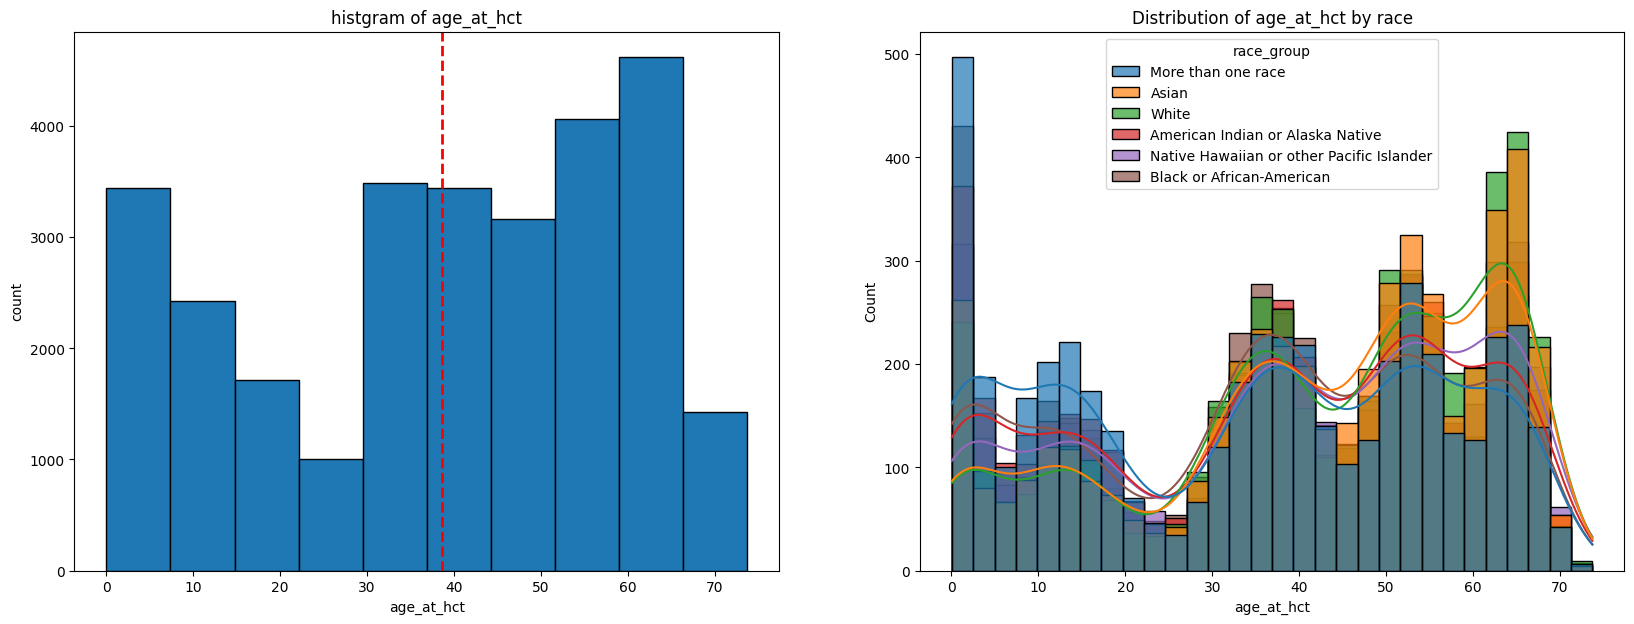

In [31]:
fig, axes = plt.subplots(1,2, figsize=(20, 7))
axes[0].hist(data['age_at_hct'].values,
         edgecolor='black')
axes[0].set_title('histgram of age_at_hct')
axes[0].set_xlabel('age_at_hct')
axes[0].set_ylabel('count')
mean_value = data['age_at_hct'].mean()
axes[0].axvline(mean_value, 
            color='red', 
            linestyle='dashed',
            linewidth=2, 
            label=f'Mean: {mean_value:.6f}')

sns.histplot(data=data, 
             x='age_at_hct', 
             hue='race_group', 
             kde=True, 
             ax=axes[1], 
             bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of age_at_hct by race')
axes[1].set_xlabel('age_at_hct')
axes[1].set_ylabel('Count')

plt.show()

## **Donor_age**

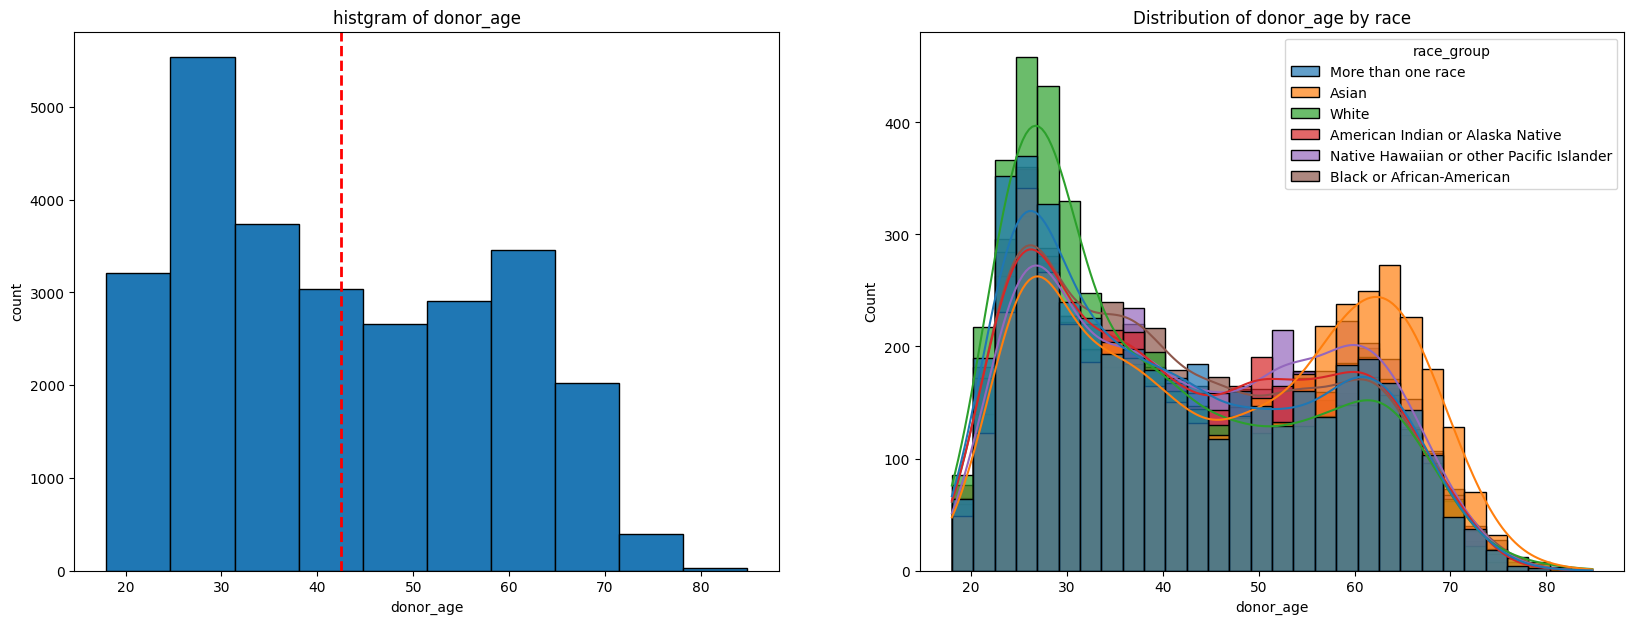

In [32]:
fig, axes = plt.subplots(1,2, figsize=(20, 7))
axes[0].hist(data['donor_age'].values,
         edgecolor='black')
axes[0].set_title('histgram of donor_age')
axes[0].set_xlabel('donor_age')
axes[0].set_ylabel('count')
mean_value = data['donor_age'].mean()
axes[0].axvline(mean_value, 
            color='red', 
            linestyle='dashed',
            linewidth=2, 
            label=f'Mean: {mean_value:.6f}')

sns.histplot(data=data, 
             x='donor_age', 
             hue='race_group', 
             kde=True, 
             ax=axes[1], 
             bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of donor_age by race')
axes[1].set_xlabel('donor_age')
axes[1].set_ylabel('Count')

plt.show()

# 全体的に20~30代が最も多く、40~50代が最も少ない。
# 特に白人のdonorは、20~30代多い。なのに、死亡率が高いのはなぜか。
# アジア人は、20~30代が少なく、その代わりに50代以降が多くなっている。


In [33]:
data['efs_time'].sort_values()

19001      0.333
1974       0.482
6920       0.523
13154      0.533
11369      0.543
          ...   
9259     153.711
9838     154.249
2226     155.283
4627     155.983
11495    156.819
Name: efs_time, Length: 28800, dtype: float64

## TARGETS4

In [34]:
data = FE.create_target4(data)

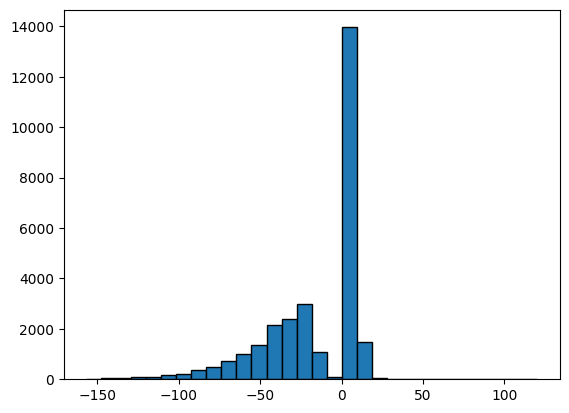

In [35]:
plt.hist(data['target4'], edgecolor='black', bins=30)
plt.show()

# **SCORE**

In [46]:
import pandas as pd
import numpy as np
from lifelines.utils import concordance_index
efs_time = pd.Series([4.5, 6.0, 7.0, 5.5, 8.0, 9.5, 4.0, 6.5, 7.5, 3.5])
prediction = pd.Series([0.3, 0.2, 0.4, 0.1, 0.1, 0.7, 0.5, 0.3, 0.4, 0.8])
efs = pd.Series([1, 1, 0, 1, 1, 0, 1, 0, 1, 1])
c_index_full = concordance_index(efs_time, -prediction, efs)
c_index_full

0.5789473684210527

In [135]:
sample=100
true_df = data[['ID', 'efs', 'efs_time', 'race_group']].copy().sample(sample)
pred = np.random.uniform(1000, 1001, size=sample)
pred_df = pd.DataFrame(true_df['ID'])
pred_df['prediction'] = pred

# display(true_df)
# display(pred_df)

score(true_df, pred_df, 'ID')

0.4201883064857119